In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load the dataset
df = pd.read_csv("../Data/heart_disease_uci.csv")
df.head()


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
# Load the data
df = pd.read_csv("../Data/heart_disease_uci.csv")

# Drop missing values (simplest way)
df.dropna(inplace=True)

# Binary target for classification
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Split features and targets
X = df.drop(['chol', 'num', 'target'], axis=1)
y_reg = df['chol']
y_clf = df['target']

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Split for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

print(X.head())          # see first 5 rows of features after encoding
print(X_train_reg.shape) # confirm shapes after split
print(X_train_reg[:5])   # print first 5 rows of scaled training data (numpy array)
print(X_train_clf.shape) # confirm shapes after split


   age  trestbps  thalch  oldpeak   ca  sex_Male  dataset_Hungary  \
0   63     145.0   150.0      2.3  0.0      True            False   
1   67     160.0   108.0      1.5  3.0      True            False   
2   67     120.0   129.0      2.6  2.0      True            False   
3   37     130.0   187.0      3.5  0.0      True            False   
4   41     130.0   172.0      1.4  0.0     False            False   

   dataset_VA Long Beach  cp_atypical angina  cp_non-anginal  \
0                  False               False           False   
1                  False               False           False   
2                  False               False           False   
3                  False               False            True   
4                  False                True           False   

   cp_typical angina  fbs_True  restecg_normal  restecg_st-t abnormality  \
0               True      True           False                     False   
1              False     False           False  

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

results = []

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        model.fit(X_train_reg, y_train_reg)
        preds = model.predict(X_test_reg)
        
        rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
        r2 = r2_score(y_test_reg, preds)
        
        results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'RMSE': rmse,
            'R2': r2
        })


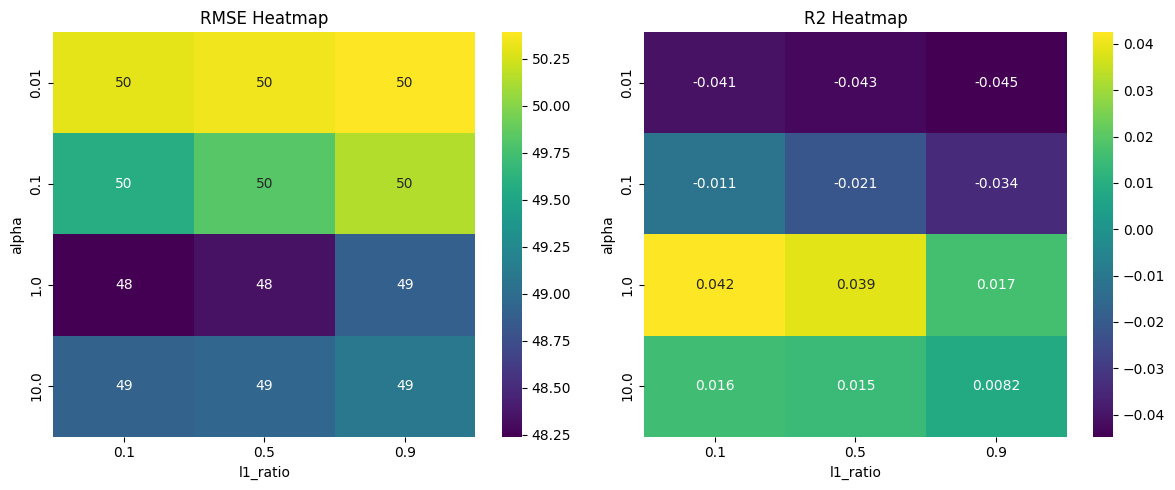

In [14]:
res_df = pd.DataFrame(results)

# Pivot tables
rmse_matrix = res_df.pivot(index='alpha', columns='l1_ratio', values='RMSE')
r2_matrix = res_df.pivot(index='alpha', columns='l1_ratio', values='R2')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(rmse_matrix, annot=True, cmap="viridis")
plt.title("RMSE Heatmap")

plt.subplot(1, 2, 2)
sns.heatmap(r2_matrix, annot=True, cmap="viridis")
plt.title("R2 Heatmap")

plt.tight_layout()
plt.show()


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

solvers = ['liblinear', 'saga']
penalties = ['l1', 'l2']

for solver in solvers:
    for penalty in penalties:
        if solver == 'liblinear' or (solver == 'saga' and penalty != 'elasticnet'):
            try:
                model = LogisticRegression(solver=solver, penalty=penalty, max_iter=5000)
                model.fit(X_train_clf, y_train_clf)
                preds = model.predict(X_test_clf)
                probs = model.predict_proba(X_test_clf)[:,1]

                print(f"{solver}-{penalty}")
                print("Accuracy:", accuracy_score(y_test_clf, preds))
                print("F1 Score:", f1_score(y_test_clf, preds))
                print("AUROC:", roc_auc_score(y_test_clf, probs))
                print("AUPRC:", average_precision_score(y_test_clf, probs))
                print("------")
            except Exception as e:
                print(f"Failed for {solver}-{penalty}", e)


liblinear-l1
Accuracy: 0.8833333333333333
F1 Score: 0.8571428571428571
AUROC: 0.9382857142857143
AUPRC: 0.9366846507171854
------
liblinear-l2
Accuracy: 0.8833333333333333
F1 Score: 0.8571428571428571
AUROC: 0.9417142857142857
AUPRC: 0.9424713825039173
------
saga-l1
Accuracy: 0.8833333333333333
F1 Score: 0.8571428571428571
AUROC: 0.9371428571428569
AUPRC: 0.9361080703083471
------
saga-l2
Accuracy: 0.8833333333333333
F1 Score: 0.8571428571428571
AUROC: 0.9417142857142857
AUPRC: 0.9424713825039173
------


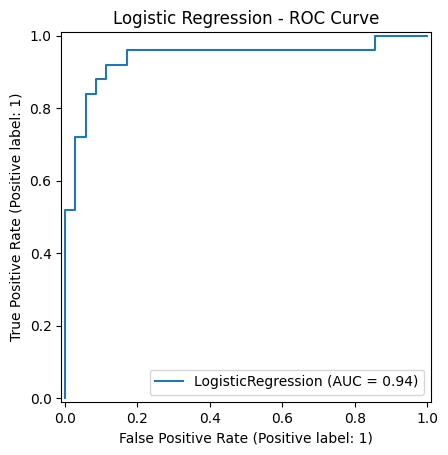

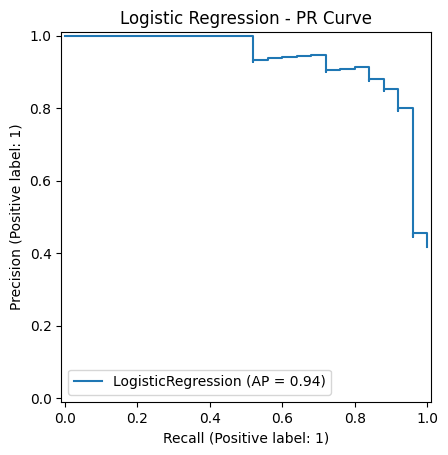

In [16]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

model = LogisticRegression(solver='liblinear', penalty='l1')
model.fit(X_train_clf, y_train_clf)
probs = model.predict_proba(X_test_clf)[:,1]

RocCurveDisplay.from_estimator(model, X_test_clf, y_test_clf)
plt.title("Logistic Regression - ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test_clf, y_test_clf)
plt.title("Logistic Regression - PR Curve")
plt.show()


In [17]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = [1, 5, 10]

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_clf, y_train_clf)
    preds = knn.predict(X_test_clf)
    probs = knn.predict_proba(X_test_clf)[:,1]

    print(f"k = {k}")
    print("Accuracy:", accuracy_score(y_test_clf, preds))
    print("F1 Score:", f1_score(y_test_clf, preds))
    print("AUROC:", roc_auc_score(y_test_clf, probs))
    print("AUPRC:", average_precision_score(y_test_clf, probs))
    print("------")


k = 1
Accuracy: 0.85
F1 Score: 0.8301886792452831
AUROC: 0.8542857142857142
AUPRC: 0.7414285714285714
------
k = 5
Accuracy: 0.8833333333333333
F1 Score: 0.8627450980392157
AUROC: 0.9188571428571428
AUPRC: 0.8671499468273662
------
k = 10
Accuracy: 0.8666666666666667
F1 Score: 0.84
AUROC: 0.9474285714285714
AUPRC: 0.9194233766233766
------


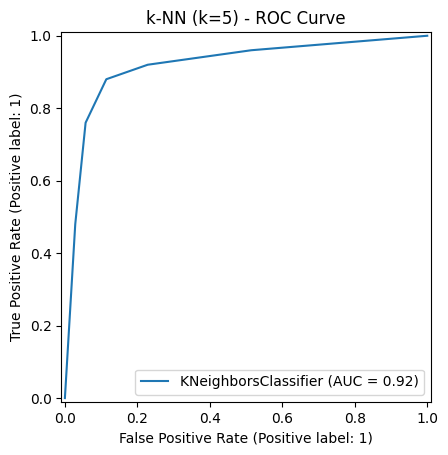

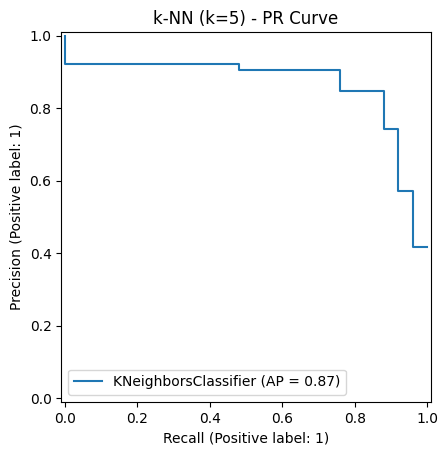

In [18]:
best_knn = KNeighborsClassifier(n_neighbors=5)
best_knn.fit(X_train_clf, y_train_clf)

RocCurveDisplay.from_estimator(best_knn, X_test_clf, y_test_clf)
plt.title("k-NN (k=5) - ROC Curve")
plt.show()

PrecisionRecallDisplay.from_estimator(best_knn, X_test_clf, y_test_clf)
plt.title("k-NN (k=5) - PR Curve")
plt.show()
